In [1]:
!pip install facenet-pytorch==2.5.3
!pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
import os, time, random, shutil
from pathlib import Path
import numpy as np, pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
import torch.backends.cudnn as cudnn

# Sklearn metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

# Misc
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
cudnn.benchmark = True

# Paths (adjust if needed)
BASE_DIR = "/kaggle/input/ff-c23/FaceForensics++_C23"
WORK_DIR = "/kaggle/working/deepfake_project"
os.makedirs(WORK_DIR, exist_ok=True)

# GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type=="cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Device: cuda
GPU: Tesla T4


In [3]:
# Cell 2: build df listing video paths and labels
folders = {
    "original": "REAL",
    "Deepfakes": "Deepfakes",
    "Face2Face": "Face2Face",
    "FaceSwap": "FaceSwap",
    "NeuralTextures": "NeuralTextures",
    "FaceShifter": "FaceShifter"
}
data=[]
for sub, label in folders.items():
    p = Path(BASE_DIR)/sub
    if p.exists():
        for f in sorted(p.iterdir()):
            if f.suffix.lower() in [".mp4", ".mov", ".avi"]:
                data.append({"video_path": str(f), "label": label})
df = pd.DataFrame(data)
print("Total videos:", len(df))
print(df.label.value_counts())
# Save df for reload after disconnect
df.to_csv(Path(WORK_DIR)/"video_list.csv", index=False)


Total videos: 6000
label
REAL              1000
Deepfakes         1000
Face2Face         1000
FaceSwap          1000
NeuralTextures    1000
FaceShifter       1000
Name: count, dtype: int64


In [4]:
# Cell 3: frame extraction utilities
FRAME_SIZE = (224,224)   # can change to 128 or 256
FRAMES_PER_VIDEO = 8     # balance speed vs data

def extract_frames_from_video(video_path, n_frames=FRAMES_PER_VIDEO, size=FRAME_SIZE):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return []
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total <= 0:
        cap.release(); return []
    # sample indices evenly
    indices = np.linspace(0, total-1, n_frames, dtype=int)
    frames=[]
    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ret, frame = cap.read()
        if not ret: break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, size)
        frames.append(frame)
    cap.release()
    return frames


In [5]:
# Cell 4: create frames folder structure (REAL vs FAKE binary)
FRAMES_ROOT = Path(WORK_DIR)/"frames_binary"
if FRAMES_ROOT.exists():
    print("Frames folder exists:", FRAMES_ROOT)
else:
    print("Creating frames in", FRAMES_ROOT)
    (FRAMES_ROOT).mkdir(parents=True, exist_ok=True)
    # iterate df and save frames (balance caution: small dataset in FF++ example)
    for i,row in tqdm(df.iterrows(), total=len(df), desc="Extracting all videos"):
        label = "REAL" if row.label=="REAL" else "FAKE"
        video_path = row.video_path
        video_name = Path(video_path).stem
        out_dir = FRAMES_ROOT/label/video_name
        out_dir.mkdir(parents=True, exist_ok=True)
        frames = extract_frames_from_video(video_path, n_frames=FRAMES_PER_VIDEO, size=FRAME_SIZE)
        for j,frm in enumerate(frames):
            out_path = out_dir/f"{j:03d}.jpg"
            # save as BGR for imwrite
            cv2.imwrite(str(out_path), cv2.cvtColor(frm, cv2.COLOR_RGB2BGR))
print("Done extracting frames.")
# quick check counts
for cls in ["REAL","FAKE"]:
    p = FRAMES_ROOT/cls
    cnt = sum(len(list(v.glob("*.jpg"))) for v in p.iterdir()) if p.exists() else 0
    print(cls, "total frames (approx):", cnt)


Creating frames in /kaggle/working/deepfake_project/frames_binary


Extracting all videos: 100%|██████████| 6000/6000 [2:35:39<00:00,  1.56s/it]

Done extracting frames.
REAL total frames (approx): 8000
FAKE total frames (approx): 8000


In [6]:
# Cell 5: dataset/dataloader
class FramesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples=[]
        self.transform = transform
        root = Path(root_dir)
        for cls_idx, cls in enumerate(sorted(os.listdir(root))):
            cls_path = root/cls
            if not cls_path.exists(): continue
            for video_folder in cls_path.iterdir():
                jpgs = sorted(video_folder.glob("*.jpg"))
                for jpg in jpgs:
                    self.samples.append((str(jpg), 0 if cls=="REAL" else 1))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path,label = self.samples[idx]
        img = cv2.imread(path)[:,:,::-1]  # BGR -> RGB
        if self.transform:
            img = self.transform(img)
        return img, label

# transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1,0.1,0.1,0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
# create dataset
full_ds = FramesDataset(FRAMES_ROOT, transform=train_transform)
print("Total frames in dataset:", len(full_ds))

# split train/val/test 70/15/15
n = len(full_ds)
n_train = int(0.7*n)
n_val = int(0.15*n)
n_test = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(full_ds, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(SEED))

# replace val/test transforms
val_ds.dataset.transform = test_transform
test_ds.dataset.transform = test_transform

# dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Train/Val/Test frames:", len(train_ds), len(val_ds), len(test_ds))


Total frames in dataset: 16000
Train/Val/Test frames: 11200 2400 2400


In [7]:
# Cell 6: shallow CNN baseline (quick)
class ShallowCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32,2)
        )
    def forward(self,x): return self.net(x)

model = ShallowCNN().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()
# single epoch quick train
model.train()
for imgs, labels in tqdm(train_loader, desc="Baseline train (1 epoch)"):
    imgs, labels = imgs.to(device), labels.to(device)
    opt.zero_grad()
    out = model(imgs)
    loss = crit(out, labels)
    loss.backward()
    opt.step()
print("Baseline train done.")


Baseline train (1 epoch): 100%|██████████| 350/350 [00:16<00:00, 21.17it/s]

Baseline train done.


In [8]:
# Cell 7: full training function with mixed precision, checkpoint, metrics
def get_model(name="resnet18", num_classes=2, pretrained=True):
    if name=="resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        m.fc = nn.Linear(m.fc.in_features, num_classes)
    else:
        raise NotImplementedError
    return m

model = get_model("resnet18").to(device)

# training utils
scaler = torch.cuda.amp.GradScaler()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

best_val_loss = float('inf')
patience = 4
counter = 0
EPOCHS = 10

history = {"train_loss":[], "val_loss":[], "val_acc":[]}

for epoch in range(EPOCHS):
    model.train()
    running=0.0; nbatch=0
    for imgs, labels in tqdm(train_loader, desc=f"Train E{epoch+1}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(imgs)
            loss = criterion(out, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running += loss.item(); nbatch += 1
    train_loss = running/nbatch
    # val
    model.eval()
    vrun=0.0; vnb=0
    all_preds=[]; all_labels=[]
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Valid"):
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                out = model(imgs)
                loss = criterion(out, labels)
            vrun += loss.item(); vnb += 1
            preds = out.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds); all_labels.extend(labels.cpu().numpy())
    val_loss = vrun/vnb
    val_acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1} TrainLoss {train_loss:.4f} ValLoss {val_loss:.4f} ValAcc {val_acc:.4f}")
    history["train_loss"].append(train_loss); history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)
    scheduler.step(val_loss)
    # checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save({"model_state":model.state_dict(), "optimizer":optimizer.state_dict(), "epoch":epoch}, Path(WORK_DIR)/"best_resnet18.pth")
        print("Saved best_resnet18.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]
/tmp/ipykernel_19/444143213.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Train E1:   0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid:   0%|          | 0/75 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cud

Epoch 1 TrainLoss 0.4782 ValLoss 0.3073 ValAcc 0.8617
Saved best_resnet18.pth


Train E2:   0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid:   0%|          | 0/75 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid: 100%|██████████| 75/75 [00:04<00:00, 17.94it/s]


Epoch 2 TrainLoss 0.2246 ValLoss 0.2660 ValAcc 0.8821
Saved best_resnet18.pth


Train E3:   0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid:   0%|          | 0/75 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid: 100%|██████████| 75/75 [00:04<00:00, 17.52it/s]


Epoch 3 TrainLoss 0.1330 ValLoss 0.2154 ValAcc 0.9050
Saved best_resnet18.pth


Train E4:   0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid:   0%|          | 0/75 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid: 100%|██████████| 75/75 [00:04<00:00, 17.58it/s]


Epoch 4 TrainLoss 0.0962 ValLoss 0.2336 ValAcc 0.9075


Train E5:   0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid:   0%|          | 0/75 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid: 100%|██████████| 75/75 [00:04<00:00, 18.41it/s]


Epoch 5 TrainLoss 0.0766 ValLoss 0.1680 ValAcc 0.9371
Saved best_resnet18.pth


Train E6:   0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid:   0%|          | 0/75 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid: 100%|██████████| 75/75 [00:04<00:00, 17.87it/s]


Epoch 6 TrainLoss 0.0617 ValLoss 0.2382 ValAcc 0.9113


Train E7:   0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid:   0%|          | 0/75 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid: 100%|██████████| 75/75 [00:04<00:00, 17.19it/s]


Epoch 7 TrainLoss 0.0538 ValLoss 0.1859 ValAcc 0.9300


Train E8:   0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid:   0%|          | 0/75 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid: 100%|██████████| 75/75 [00:04<00:00, 17.88it/s]


Epoch 8 TrainLoss 0.0453 ValLoss 0.3185 ValAcc 0.8988


Train E9:   0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid:   0%|          | 0/75 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid: 100%|██████████| 75/75 [00:04<00:00, 17.00it/s]


Epoch 9 TrainLoss 0.0185 ValLoss 0.1612 ValAcc 0.9429
Saved best_resnet18.pth


Train E10:   0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid:   0%|          | 0/75 [00:00<?, ?it/s]/tmp/ipykernel_19/444143213.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Valid: 100%|██████████| 75/75 [00:04<00:00, 17.93it/s]

Epoch 10 TrainLoss 0.0136 ValLoss 0.1757 ValAcc 0.9483


Testing: 100%|██████████| 75/75 [00:04<00:00, 15.99it/s]


Test Acc: 0.9520833333333333
Classification report:
               precision    recall  f1-score   support

           0     0.9576    0.9456    0.9516      1195
           1     0.9467    0.9585    0.9526      1205

    accuracy                         0.9521      2400
   macro avg     0.9522    0.9521    0.9521      2400
weighted avg     0.9522    0.9521    0.9521      2400



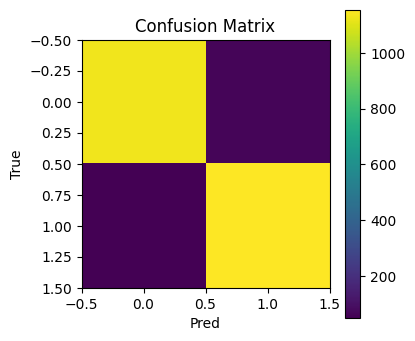

In [9]:
# Cell 8: load best model, evaluate test set
ckpt = torch.load(Path(WORK_DIR)/"best_resnet18.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()
all_preds=[]; all_labels=[]
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(device)
        out = model(imgs)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds); all_labels.extend(labels.numpy())
print("Test Acc:", accuracy_score(all_labels, all_preds))
print("Classification report:\n", classification_report(all_labels, all_preds, digits=4))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar(); plt.xlabel("Pred"); plt.ylabel("True")
plt.show()


In [10]:
# Cell 9: export best model to TorchScript and ONNX for deployment
model.eval()
example = torch.randn(1,3,FRAME_SIZE[0],FRAME_SIZE[1]).to(device)
# TorchScript
traced = torch.jit.trace(model, example)
traced.save(Path(WORK_DIR)/"resnet18_traced.pt")
print("Saved TorchScript at", Path(WORK_DIR)/"resnet18_traced.pt")
# ONNX
onnx_path = Path(WORK_DIR)/"resnet18.onnx"
torch.onnx.export(model, example, onnx_path, input_names=["input"], output_names=["output"], opset_version=12)
print("Saved ONNX at", onnx_path)


Saved TorchScript at /kaggle/working/deepfake_project/resnet18_traced.pt
Saved ONNX at /kaggle/working/deepfake_project/resnet18.onnx


In [11]:
# Cell 10: real-time inference function (use webcam=0 or a video file)
def realtime_detect_from_video(model, source=0):
    model.eval()
    cap = cv2.VideoCapture(source)
    while True:
        ret, frame = cap.read()
        if not ret: break
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, FRAME_SIZE)
        tensor = transforms.ToTensor()(img)
        tensor = transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])(tensor).unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(tensor)
            prob = torch.softmax(out, dim=1)[0].cpu().numpy()
            pred = prob.argmax()
            label = "REAL" if pred==0 else "FAKE"
            conf = prob[pred]
        color = (0,255,0) if label=="REAL" else (0,0,255)
        cv2.putText(frame, f"{label} {conf:.2f}", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
        cv2.imshow("Real-Time Deepfake Detection", frame)
        if cv2.waitKey(1)&0xFF==ord('q'): break
    cap.release(); cv2.destroyAllWindows()

# To run (uncomment when you have camera access):
# realtime_detect_from_video(model, source=0)


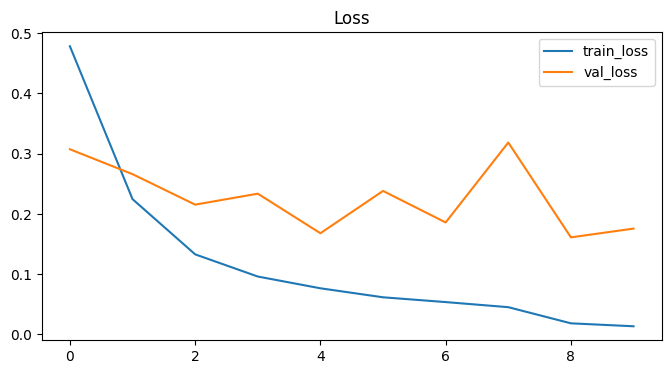

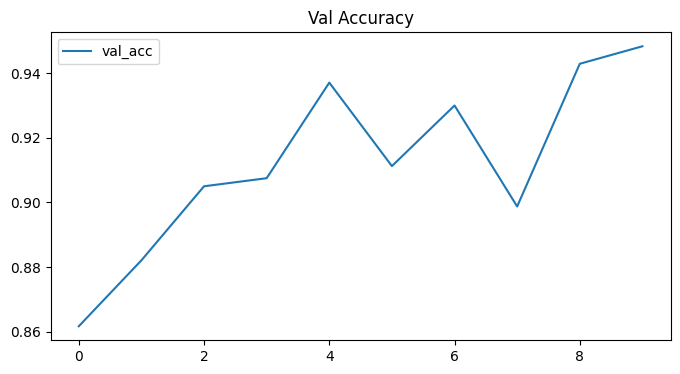

In [12]:
# Cell 11: plot saved history from training
plt.figure(figsize=(8,4))
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss")
plt.show()
plt.figure(figsize=(8,4))
plt.plot(history["val_acc"], label="val_acc")
plt.legend(); plt.title("Val Accuracy")
plt.show()


In [13]:
# Cell 12: Prepare deliverables
# - best_resnet18.pth (weights)
# - resnet18_traced.pt (torchscript)
# - resnet18.onnx (onnx)
# - training plots saved
out = Path(WORK_DIR)
# Save report info
with open(out/"report_summary.txt","w") as f:
    f.write("DeepFake Detection Project — Summary\n")
    f.write(f"Device: {device}\n")
    f.write(f"Total frames: {len(full_ds)}\n")
    f.write(f"Train/Val/Test sizes: {len(train_ds)},{len(val_ds)},{len(test_ds)}\n")
    f.write(f"Best val loss: {best_val_loss}\n")
print("Deliverables ready at", out)


Deliverables ready at /kaggle/working/deepfake_project


In [14]:
torch.save(model.state_dict(), "/kaggle/working/deepfake_model.pth")


In [15]:
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

correct = 0
total = 0
loss_total = 0.0

criterion = torch.nn.CrossEntropyLoss() 

with torch.no_grad():
    for inputs, labels in tqdm(test_loader): 
        inputs, labels = inputs.to(device), labels.to(device).long()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        preds = torch.argmax(outputs, dim=1)  
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loss_total += loss.item()

test_acc = correct / total
avg_loss = loss_total / len(test_loader)

print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Average Test Loss: {avg_loss:.4f}")


100%|██████████| 75/75 [00:04<00:00, 17.13it/s]

Test Accuracy: 95.21%
Average Test Loss: 0.1440
